# Homework #7

This homework will cover a mix of parallelization and running MPI jobs on the cluster.  Hence, some of the problems will require running (short) jobs on Rivanna.

**homework7.py** This homework is unusual in that there is no need to create a `homework7.py` file. Instead you will be creating or modifying several files as part of the homework, as described in each problem below.  Changes to tracked files need to be committed and new files added to the repo (e.g. `git add scaling.tab`) and pushed to GitHub.

**Group work**:  You do not have to do this as a group, but I would encourage students to perform the scaling test in problem 1 in groups of 2-3 since this will cut down on the jobs run concurrently on the same account.  My worry is that if we all try to run it at once, the jobs may wait in the queue for a long time.  Try to do this problem early in the week to avoid a long wait in the queue!  If you do this as a group, please note who your fellow group members are in the problem below.

## Problem 1

Let's peform a weak scaling test on Rivanna. We will use my favorite code: Athena++. Now, some of you may be assuming that I keep using/referencing Athena++ simply because I am lazy and that is the code that I know how to use the best. While this is correct on both accounts, another reason for choosing Athena++ is its relative lack of dependence on libraries.  This means that it is one of the easier codes to get up and running fast without having to install dependent software.

Start by logging into Rivanna.  I should have demonstrated this in class, but the command from a Linux machines would be
```
ssh -X swd8g@rivanna.hpc.virginia.edu
```
Obviously, you should replace my username with your username. You should arrive in your home directory.  Recall that you can use the `pwd` command to check your current directory. You should be able clone the public version of athena here
```
git clone https://github.com/PrincetonUniversity/athena.git
```
This should create a directory called athena.  Now configure the code to run the linear_wave test in pure hydrodynamics. The sequence of commands for this follows. First, we load the necessary modules for compilign with mpi:
```
module purge
module load gcc
module load openmpi
module load python
```
The purge may not be necessary, but it cannot hurt to get rid of any uneeded loaded modules. You can confirm the modules loaded correctly with
```
module list
```
You should see a few extra modules that were loaded because openmpi and gcc depend on these. You can also see that there are specific default versions of these modules.

Next, we cd into the athena directory, configure the code, and then compile
```
cd athena
python configure.py --prob=linear_wave -mpi
make all
```
The `configure.py` creates a makefile that is then executed by calling `make`.

Now make sure you copy over the `slurm.athena` file that is included in this week's repo.  You can do this by cloning the repo to your home directory on Rivanna or using `scp` to copy it from its location (your computer, the Dell server, etc.) to Rivanna.

You will want to run the jobs from your scratch directory on Rivanna. For me this will be `/scratch/swd8g` since my user id is `swd8g`. So cd to the corresponding directory for your account and make directories for running the scaling test. Then copy the `athinput.linear_wave3d` and `slurm.athena` codes to this directory.
```
cd /scratch/swd8g  (change to your directory)
mkdir scaling
cd scaling
mkdir run01
mkdir run02
mkdir run04
mkdir run08
mkdir run16
mkdir run32
mkdir run64
cp /home/swd8g/athinput.linear_wave3d .
cp /home/swd8g/slurm.athena .
```
Now proceed with the weak scaling survey. Lets start with a single core. Copy the athinput.linear_wave3d and slurm.athena files into run01. I have written these so that they should run the problem and produce 50 output vtk files. Then launch the scipt
```
cp athinput.linear_wave3d run01
cp slurm.athena run01
cd run01
sbatch slurm.athena
```
This will submit your job to the slurm scheduler.  You can check if your job is running by typing
```
squeue -u swd8g
```
where you would replace `swd8g` with your username.  If your job is running, it should have an R the status column.  If there not sufficient notes running, it may show up as PD for pending. You should have wait long. If it is running it should be producing files with the ".vtk" extension. When it finishes there should be a file named `slurm-######.out` where `######` is the job id number.  You can look at this file with the less command
```
less slurm-######.out
```
which show the standard diagnostic output of Athena++. This should include information about each timestep and then at the end some assessment of the codes performance. To just look at the last few lines, type
```
tail slurm-######.out
```
In my case the last three lines are
```
zone-cycles = 23330816
cpu time used  = 1.2722564999999999e+01
zone-cycles/cpu_second = 1.8338138575043634e+06
```
This last number is the key metric for performance -- it is how many simulation cells get updated per cpu-second for the entire job.  You want to record this number in a file 'scaling.tab` with two columns -- the first number is number of cores used and the second number is zone-cycles/cpu_second.

Now, change to the next directory `run02` and copy the `slurm.athena` and `athinput.linear_wave3d'
```
cd ../run02
cp ../run01/athinput.linear_wave3d .
cp ../run02/slurm.athena .
```
Now edit the `slurm.athena` script to change the following lines;
```
#SBATCH --ntasks=2
#SBATCH -J wkath2
```
Then edit the `athinput.linear_wave3d` to change
```
nx1        = 128
```
This doubles the size of the job and number of cores used. Now submit the new job
```
sbatch slurm.athena
```
Continue this for each runs, doubling `n` in the  `#SBATCH --ntasks=n` line of the script and changing the job name so that you can tell which is which in the queue.  Each time you will want to double the size of the job by increaseing `nx1`, `nx2` and `nx3` in the `athinput.linear_wave3d` file. I reccomdend increasing these in order: for `run04` keep `nx1=128` and `nx3=32` but double `nx2` so that it equals 64. For `run08` keep `nx1=128` and `nx2=64` but make `nx3=64. Then double `nx1` for the next run and so on.

Rivanna's primary nodes only have 20 cores.  This means that when you go from 16 to 32 processes, you will need to increase the nodes to 2 and change to the parallel queue:
```
#SBATCH --nodes=2
#SBATCH --ntasks=32
#SBATCH --partition=parallel
```
Continue this up to 64 core runs to complete `scaling.tab`.

Now plot the weak scaling efficiency.  Often this printed relative to single core performance so we will divide by the performance with `--ntasks=1`. One usually expect efficiency to drop as the number of processes increases.  For a single node (N < 20 on Rivanna), you often see efficiency drop due to increase shared memory usage as the number of active cores increases, but this depends on the queuing system and whether or not other users have access to the same node.

For jobs exceeding a single node, one often measures efficiency on multiple (full) nodes relative to the performance on a single node.

Our scaling test is not entirely optimal because we are not using full nodes, but you should genreally see efficiency decline as the number of processes increases.

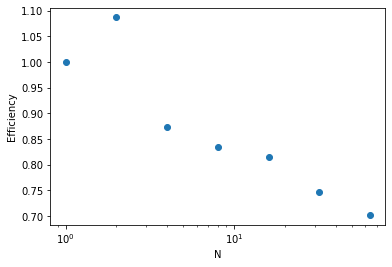

In [129]:
import numpy as np
import matplotlib.pyplot as plt
tab = np.loadtxt("scaling.tab")

nproc = tab[:,0]
effic = tab[:,1]/tab[:,0]/tab[0,1] # normalize to single node

plt.plot(nproc, effic, 'o')
plt.ylabel('Efficiency')
plt.xlabel('N')
plt.xscale('log')

If you did the test as a group, list the other group members here:

Add `scaling.tab` to the git repo using `git add scaling.tab`.

## Problem 2

For this problem we revisit our solution of Poisson's equation using Jacobi iteration. In our notebook, we implemented this using blocking sends and receives. Now try implementing with non-blocking sends and receives by updating the file `jacobi_nb.py`. In particularly, we will attemp to interleave communication and computation by initiating the send and receive calls *before* our call to the `jacobi()` function.  We only need to compute the endpoints of the local grid (`phi[1]` and `phi[-2]`) to pass to neighboring processes so we simply compute these first and then send it before doing the full problem by calling `jacobi()`. Will this improve our performance?  First comput the case with one process -- this should work without modification.

In [107]:
import subprocess
subprocess.run(["mpirun","-np","1","python","jacobi_nb.py"])

Total iteration: 17677 9.999e-08
Time with 1 processors: 2.748570e-01


CompletedProcess(args=['mpirun', '-np', '1', 'python', 'jacobi_nb.py'], returncode=0)

This should take the same number of iterations as in the noteboock and will produce a file called `jacobi_nb.png` that should look like identical to the notebook plot.  Now modify the `main()` fucntion to work with multiple processes and try four processes below.

In [108]:
import subprocess
subprocess.run(["mpirun","-np","4","python","jacobi_nb.py"])

Total iteration: 1303 9.899e-08
Time with 4 processors: 3.656400e-02


CompletedProcess(args=['mpirun', '-np', '4', 'python', 'jacobi_nb.py'], returncode=0)

If you did this correctly, it should again take the exact same number of iterations and procude an identical plot to what you obtain with a single process. Unfortunately, initiating the communication before the call to the `jacobi()` function didn't help much here.  It is simply the case that (on most machines) the communication overhead (latency) is much larger than the cost to perform `jacobi()` for a problem of this size. This was not a problem worth parallelizing for Python outside of pedagogical motivations. 

## Problem 3 (grads only)

Recall that when we first implemented iterative solutions of matrix equations, we discussed both the Jacobi method and the Gauss-Seidel method, with Gauss-Seidel being faster because it incorporates new information.  At the time I mentioned that Jacobi is sometime still used because it parallelizes more efficiently.  The problem with Gauss-Seidel is that you need to incorporate new information (which may be on the other process) to make it converge more efficiently.

In order to get around this, we can use a method called Red-Black Gauss-Seidel.  This is a two step method, where you only update every other cell/point in the grid on each substep. For example in 1D, you would first update $i=0,2,4,\dots$ and then on the next step $i=1,3,5,\dots$.  In 2D this looks like a checkerboard patter -- hence the name red-black Guass-Seidel.

Let's try this on our current 1D problem. Since non-blocking communication didn't help much in problem 2, lets stick to blocking communication.  Below is an example of the Red-black Gauss-Seidel iteration that gives us some practice with NumPy slicing gymanstics.  Recall that the general slice is `begin:end:step`. Something like `3::2` means begin with 3 and take a step of 2. The blank between the two colons means no end is set (i.e. go until the end of the array). If no step is specified, it is set to 1. Here we are using steps of 2 to implement the algorithm.

In [ ]:
def gaussseidel_redblack(phi, x, rho):
    # red
    dx = 0.5*(x[3::2] - x[1:-2:2])
    phi[2:-1:2] = 0.5*(phi[1:-2:2] + phi[3::2] - dx**2*rho[2:-1:2])
    # black
    dx = 0.5*(x[2::2] - x[:-2:2])
    phi[1:-1:2] = 0.5*(phi[:-2:2]  + phi[2::2] - dx**2*rho[1:-1:2])
    return phi

### Part a

Before you implement the MPI changes, begin by implementing the `gaussseidel_red()` and `gaussseidel_black()` functions and test it on a single process.

In [114]:
import subprocess
subprocess.run(["mpirun","-np","1","python","gaussseidel.py"])

Total iteration: 9300 9.994e-08
Time with 1 processors: 2.111800e-01


CompletedProcess(args=['mpirun', '-np', '1', 'python', 'gaussseidel.py'], returncode=0)

If you did it correctly, it should only take 9300 iterations -- considerably less than what we found for the Jacobi method. It should also produce a figure `gaussseidel.png` where the converged solution matches the analytics result.

### Part b

Now implement the MPI communication following the previous examples. The only trick bit here is that `gaussseidel_black()` requires the updates from `gaussseidel_red()` so we need to perform one set of send/receive in-between the functions calls. You need to figure out which one yourself. Try it with four processes:

In [116]:
import subprocess
subprocess.run(["mpirun","-np","4","python","gaussseidel.py"])

Total iteration: 683 9.867e-08
Time with 4 processors: 2.369400e-02


CompletedProcess(args=['mpirun', '-np', '4', 'python', 'gaussseidel.py'], returncode=0)

If you did it correctly, it should take the same number of iterations and the plotted solution should match the analtyics result.  Still slower -- we haven't actually increased the amount of work to be done so communication continues to dominate the cost of the calculation. Sad!

## Problem 4

Now lets try writing our own OpenMP code and running it on the Rivanna cluster.